In [2]:
import sys
sys.path.append('../')
import os
import glob
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from lib.preprocessing import *
from lib.dataloading import *
from lib.loss_functions import *
from lib.evaluation import *
from torchvision import transforms
from torchvision.transforms import CenterCrop
import torchvision.models as models
from torch import optim, nn
from skimage.color import rgb2gray

In [9]:
%matplotlib inline

In [3]:
transforms = get_transformer_norm()
dataset = SSIDataset(transform=transforms['val'], output_resize = True)

In [4]:
original = SSIDataset(inpaint = False)

In [5]:
def min_max(img):
    min = np.min(img)
    max = np.max(img)
    img = (img - min)/(max-min)
    return img

In [11]:
i = random.randint(0, len(dataset))
img, center, label = dataset[i]

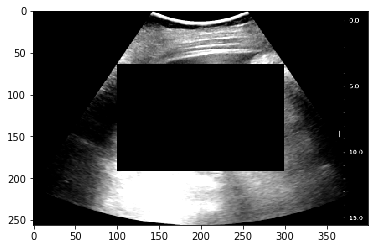

In [12]:
img = np.rollaxis(img.numpy(), 0 ,3)
img = min_max(img)                  
plt.imshow(img, cmap='gray')
plt.show()

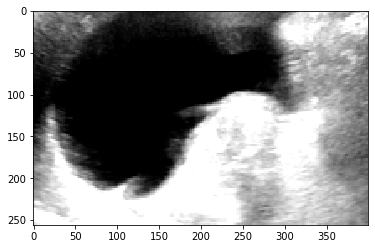

In [13]:
center = np.rollaxis(center.numpy(), 0 ,3)
center = min_max(center)                  
plt.imshow(center, cmap='gray')

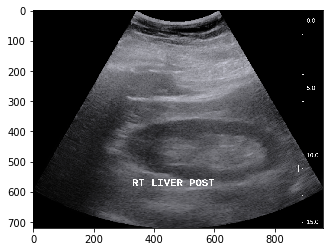

In [15]:
ori_img = original[i]
plt.imshow(ori_img, cmap='gray')

In [29]:
batch_size = 4
dataloader = torch.utils.data.DataLoader(dataset, batch_size= batch_size)
dlabel = torch.FloatTensor(batch_size)

In [25]:
net = CENet()        
        
discriminator = Discriminator(9)
        
criteriaMSE = nn.MSELoss()
criteriaBCE = nn.BCELoss()
        
        
# Define the optimizer for the network
optG = optim.Adam(net.parameters(), lr = 0.001)         
optD = optim.Adam(discriminator.parameters(), lr = 0.001)

In [41]:
pred_dicom

tensor([[0.5130, 0.4628, 0.5434, 0.5370, 0.5040, 0.4703, 0.4673, 0.4929],
        [0.4984, 0.4655, 0.5519, 0.5282, 0.5087, 0.4687, 0.4580, 0.5166],
        [0.5341, 0.4976, 0.5445, 0.5378, 0.5034, 0.4723, 0.5109, 0.4617],
        [0.5096, 0.4572, 0.5380, 0.5454, 0.4942, 0.4557, 0.4887, 0.4897]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [57]:
epochs = 100
device = 'cuda:0'
net = net.to(device)
discriminator = discriminator.to(device)
dlabel = dlabel.to(device)
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    epoch_loss = 0            

    for i, (imgs, centers, dcm_labels) in enumerate(dataloader):
        imgs, centers, dcm_labels = imgs.to(device), centers.to(device), dcm_labels.to(device)                       
        # Discriminator - Train with real
        discriminator.zero_grad()
        dlabel.data.resize_(batch_size).fill_(1)
        
        output = discriminator(centers)
        
        pred_dlabel = output[:,0]
        pred_dicom = output[:,1:]
        
        lossAdv_real = criteriaBCE(pred_dlabel, dlabel)        
        lossDCM = criteriaBCE(pred_dicom, dcm_labels.float())
        
                
        # Discriminator - Train with fake
        pred_centers = net(imgs)
        dlabel.data.resize_(batch_size).fill_(0)
        
        output = discriminator(pred_centers)
        pred_dlabel = output[:, 0]
        lossAdv_fake = criteriaBCE(pred_dlabel, dlabel)
        
        lossD = lossAdv_real + lossAdv_fake + lossDCM
        lossD.backward()
        optD.step()
        
        
        # Encoder
        net.zero_grad()        
        pred_centers = net(imgs)
        
        dlabel.data.resize_(batch_size).fill_(1)
        output = discriminator(pred_centers)
        pred_dlabel = output[:, 0]
        lossAdv_Encoder = criteriaBCE(pred_dlabel, dlabel)
        
        lossMSE_Encoder = criteriaMSE(pred_centers, centers)
        
        lossG = lossAdv_Encoder + lossMSE_Encoder
        lossG.backward()
        optG.step()
                                

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
              % (epoch, epochs, i, len(dataloader),
                 lossD.item(), lossG.item()))    


Starting epoch 1/100.
[0/100][0/3067] Loss_D: 2.0574 Loss_G: 2.8196
[0/100][1/3067] Loss_D: 2.0340 Loss_G: 2.6106
[0/100][2/3067] Loss_D: 2.1315 Loss_G: 2.4673
[0/100][3/3067] Loss_D: 2.2005 Loss_G: 2.0557
[0/100][4/3067] Loss_D: 2.1998 Loss_G: 2.4474
[0/100][5/3067] Loss_D: 2.2166 Loss_G: 1.8985
[0/100][6/3067] Loss_D: 2.2581 Loss_G: 2.5475
[0/100][7/3067] Loss_D: 2.3075 Loss_G: 2.8651
[0/100][8/3067] Loss_D: 2.3373 Loss_G: 3.0347
[0/100][9/3067] Loss_D: 2.3910 Loss_G: 2.9765
[0/100][10/3067] Loss_D: 2.3882 Loss_G: 2.9218
[0/100][11/3067] Loss_D: 2.3663 Loss_G: 3.0238
[0/100][12/3067] Loss_D: 2.3783 Loss_G: 3.1729
[0/100][13/3067] Loss_D: 2.4172 Loss_G: 2.8394
[0/100][14/3067] Loss_D: 2.4496 Loss_G: 2.5936
[0/100][15/3067] Loss_D: 2.4840 Loss_G: 2.7240
[0/100][16/3067] Loss_D: 2.5488 Loss_G: 3.0332
[0/100][17/3067] Loss_D: 2.5800 Loss_G: 4.1741
[0/100][18/3067] Loss_D: 2.7204 Loss_G: 4.1900
[0/100][19/3067] Loss_D: 2.9219 Loss_G: 4.4507
[0/100][20/3067] Loss_D: 2.8933 Loss_G: 4.0955
[

[0/100][173/3067] Loss_D: 6.2196 Loss_G: 6.4204
[0/100][174/3067] Loss_D: 6.2193 Loss_G: 6.4406
[0/100][175/3067] Loss_D: 6.3381 Loss_G: 6.4312
[0/100][176/3067] Loss_D: 6.3525 Loss_G: 6.5180
[0/100][177/3067] Loss_D: 6.3470 Loss_G: 6.5164
[0/100][178/3067] Loss_D: 6.3978 Loss_G: 6.5475
[0/100][179/3067] Loss_D: 6.4471 Loss_G: 6.5306
[0/100][180/3067] Loss_D: 6.4502 Loss_G: 6.3557
[0/100][181/3067] Loss_D: 6.5568 Loss_G: 6.5690
[0/100][182/3067] Loss_D: 6.4810 Loss_G: 6.7991
[0/100][183/3067] Loss_D: 6.5201 Loss_G: 6.6747
[0/100][184/3067] Loss_D: 6.5200 Loss_G: 6.8026
[0/100][185/3067] Loss_D: 6.5474 Loss_G: 6.6912
[0/100][186/3067] Loss_D: 6.5557 Loss_G: 6.6083
[0/100][187/3067] Loss_D: 6.5572 Loss_G: 6.7543
[0/100][188/3067] Loss_D: 6.5758 Loss_G: 6.6390
[0/100][189/3067] Loss_D: 6.5450 Loss_G: 6.8381
[0/100][190/3067] Loss_D: 6.5543 Loss_G: 6.7225
[0/100][191/3067] Loss_D: 6.6036 Loss_G: 6.8585
[0/100][192/3067] Loss_D: 6.6033 Loss_G: 6.5933
[0/100][193/3067] Loss_D: 6.6247 Loss_G:

[0/100][344/3067] Loss_D: 7.0753 Loss_G: 7.2169
[0/100][345/3067] Loss_D: 7.0282 Loss_G: 7.2619
[0/100][346/3067] Loss_D: 6.9645 Loss_G: 6.9723
[0/100][347/3067] Loss_D: 7.1491 Loss_G: 6.8859
[0/100][348/3067] Loss_D: 7.1365 Loss_G: 7.0349
[0/100][349/3067] Loss_D: 7.2610 Loss_G: 7.3281
[0/100][350/3067] Loss_D: 7.2988 Loss_G: 7.1629
[0/100][351/3067] Loss_D: 7.3322 Loss_G: 7.2093
[0/100][352/3067] Loss_D: 7.3251 Loss_G: 7.2476
[0/100][353/3067] Loss_D: 7.3692 Loss_G: 7.1889
[0/100][354/3067] Loss_D: 7.4794 Loss_G: 6.6879
[0/100][355/3067] Loss_D: 7.5545 Loss_G: 6.5607
[0/100][356/3067] Loss_D: 7.5770 Loss_G: 6.8682
[0/100][357/3067] Loss_D: 7.4534 Loss_G: 6.8202
[0/100][358/3067] Loss_D: 7.4421 Loss_G: 7.2731
[0/100][359/3067] Loss_D: 7.4630 Loss_G: 6.8154
[0/100][360/3067] Loss_D: 7.5623 Loss_G: 6.7031
[0/100][361/3067] Loss_D: 7.2897 Loss_G: 7.6521
[0/100][362/3067] Loss_D: 7.5559 Loss_G: 7.1049
[0/100][363/3067] Loss_D: 7.6017 Loss_G: 6.7648
[0/100][364/3067] Loss_D: 7.2972 Loss_G:

[0/100][515/3067] Loss_D: 8.7441 Loss_G: 7.5301
[0/100][516/3067] Loss_D: 8.8891 Loss_G: 7.8207
[0/100][517/3067] Loss_D: 8.7756 Loss_G: 7.5901
[0/100][518/3067] Loss_D: 8.7638 Loss_G: 7.7299
[0/100][519/3067] Loss_D: 8.7297 Loss_G: 7.3288
[0/100][520/3067] Loss_D: 8.7133 Loss_G: 7.3576
[0/100][521/3067] Loss_D: 8.8281 Loss_G: 7.8367
[0/100][522/3067] Loss_D: 8.8977 Loss_G: 8.7659
[0/100][523/3067] Loss_D: 8.8385 Loss_G: 7.8965
[0/100][524/3067] Loss_D: 8.8750 Loss_G: 8.5380
[0/100][525/3067] Loss_D: 8.9017 Loss_G: 8.3175
[0/100][526/3067] Loss_D: 8.9191 Loss_G: 8.7838
[0/100][527/3067] Loss_D: 8.8617 Loss_G: 7.9009
[0/100][528/3067] Loss_D: 8.8965 Loss_G: 8.5572
[0/100][529/3067] Loss_D: 8.9020 Loss_G: 8.5013
[0/100][530/3067] Loss_D: 8.8509 Loss_G: 8.4623
[0/100][531/3067] Loss_D: 8.9518 Loss_G: 8.9811
[0/100][532/3067] Loss_D: 8.9044 Loss_G: 8.4850
[0/100][533/3067] Loss_D: 8.9448 Loss_G: 8.8353
[0/100][534/3067] Loss_D: 8.9873 Loss_G: 8.0363
[0/100][535/3067] Loss_D: 8.9700 Loss_G:

[0/100][686/3067] Loss_D: 9.5652 Loss_G: 8.7401
[0/100][687/3067] Loss_D: 9.5446 Loss_G: 10.4064
[0/100][688/3067] Loss_D: 9.5585 Loss_G: 10.2431
[0/100][689/3067] Loss_D: 9.5109 Loss_G: 8.9675
[0/100][690/3067] Loss_D: 9.5307 Loss_G: 9.0380
[0/100][691/3067] Loss_D: 9.3717 Loss_G: 8.8078
[0/100][692/3067] Loss_D: 9.4963 Loss_G: 8.6631
[0/100][693/3067] Loss_D: 9.5277 Loss_G: 8.6845
[0/100][694/3067] Loss_D: 9.5020 Loss_G: 8.8042
[0/100][695/3067] Loss_D: 9.4660 Loss_G: 8.7114
[0/100][696/3067] Loss_D: 9.5790 Loss_G: 9.3313
[0/100][697/3067] Loss_D: 9.5743 Loss_G: 9.0911
[0/100][698/3067] Loss_D: 9.4314 Loss_G: 8.8479
[0/100][699/3067] Loss_D: 9.5595 Loss_G: 8.8416
[0/100][700/3067] Loss_D: 9.5816 Loss_G: 8.9356
[0/100][701/3067] Loss_D: 9.6737 Loss_G: 9.4375
[0/100][702/3067] Loss_D: 9.5414 Loss_G: 9.1074
[0/100][703/3067] Loss_D: 9.6819 Loss_G: 9.1494
[0/100][704/3067] Loss_D: 9.6115 Loss_G: 9.0838
[0/100][705/3067] Loss_D: 9.5793 Loss_G: 9.1810
[0/100][706/3067] Loss_D: 9.6660 Loss_

[0/100][857/3067] Loss_D: 9.8334 Loss_G: 9.2094
[0/100][858/3067] Loss_D: 9.7411 Loss_G: 9.0278
[0/100][859/3067] Loss_D: 9.7931 Loss_G: 9.3151
[0/100][860/3067] Loss_D: 9.8334 Loss_G: 9.4136
[0/100][861/3067] Loss_D: 9.9691 Loss_G: 9.4848
[0/100][862/3067] Loss_D: 10.0634 Loss_G: 9.3863
[0/100][863/3067] Loss_D: 10.0697 Loss_G: 9.2847
[0/100][864/3067] Loss_D: 9.8400 Loss_G: 8.9953
[0/100][865/3067] Loss_D: 9.9593 Loss_G: 9.1619
[0/100][866/3067] Loss_D: 9.9478 Loss_G: 8.9298
[0/100][867/3067] Loss_D: 9.9305 Loss_G: 9.2348
[0/100][868/3067] Loss_D: 9.7687 Loss_G: 8.9698
[0/100][869/3067] Loss_D: 9.7881 Loss_G: 9.0058
[0/100][870/3067] Loss_D: 9.9347 Loss_G: 9.6719
[0/100][871/3067] Loss_D: 10.0271 Loss_G: 9.9506
[0/100][872/3067] Loss_D: 10.0187 Loss_G: 9.8489
[0/100][873/3067] Loss_D: 9.9509 Loss_G: 9.2850
[0/100][874/3067] Loss_D: 9.9843 Loss_G: 8.9686
[0/100][875/3067] Loss_D: 9.9544 Loss_G: 8.8766
[0/100][876/3067] Loss_D: 9.9296 Loss_G: 9.4765
[0/100][877/3067] Loss_D: 10.0860 Lo

[0/100][1027/3067] Loss_D: 9.9543 Loss_G: 8.5887
[0/100][1028/3067] Loss_D: 10.0273 Loss_G: 8.8550
[0/100][1029/3067] Loss_D: 9.9446 Loss_G: 9.6354
[0/100][1030/3067] Loss_D: 10.1126 Loss_G: 8.8140
[0/100][1031/3067] Loss_D: 9.9797 Loss_G: 9.1358
[0/100][1032/3067] Loss_D: 10.1316 Loss_G: 8.8417
[0/100][1033/3067] Loss_D: 10.0556 Loss_G: 9.0848
[0/100][1034/3067] Loss_D: 10.1602 Loss_G: 9.2717
[0/100][1035/3067] Loss_D: 10.2541 Loss_G: 9.4278
[0/100][1036/3067] Loss_D: 10.2497 Loss_G: 9.3617
[0/100][1037/3067] Loss_D: 10.2623 Loss_G: 9.3780
[0/100][1038/3067] Loss_D: 10.2526 Loss_G: 9.2999
[0/100][1039/3067] Loss_D: 10.1952 Loss_G: 9.2954
[0/100][1040/3067] Loss_D: 10.1996 Loss_G: 9.2997
[0/100][1041/3067] Loss_D: 10.2592 Loss_G: 9.4155
[0/100][1042/3067] Loss_D: 10.1539 Loss_G: 8.9472
[0/100][1043/3067] Loss_D: 10.3423 Loss_G: 9.3546
[0/100][1044/3067] Loss_D: 10.1537 Loss_G: 9.4689
[0/100][1045/3067] Loss_D: 10.3275 Loss_G: 9.6995
[0/100][1046/3067] Loss_D: 10.2063 Loss_G: 9.1372
[0/

[0/100][1190/3067] Loss_D: 10.3986 Loss_G: 9.3830
[0/100][1191/3067] Loss_D: 10.5650 Loss_G: 10.6049
[0/100][1192/3067] Loss_D: 10.6264 Loss_G: 10.6690
[0/100][1193/3067] Loss_D: 10.6211 Loss_G: 10.2333
[0/100][1194/3067] Loss_D: 10.6048 Loss_G: 10.1870
[0/100][1195/3067] Loss_D: 10.5766 Loss_G: 10.2519
[0/100][1196/3067] Loss_D: 10.5258 Loss_G: 10.3590
[0/100][1197/3067] Loss_D: 10.6293 Loss_G: 10.2473
[0/100][1198/3067] Loss_D: 10.6345 Loss_G: 10.1033
[0/100][1199/3067] Loss_D: 10.4399 Loss_G: 10.7971
[0/100][1200/3067] Loss_D: 10.6203 Loss_G: 10.2440
[0/100][1201/3067] Loss_D: 10.4349 Loss_G: 10.7468
[0/100][1202/3067] Loss_D: 10.4899 Loss_G: 10.2722
[0/100][1203/3067] Loss_D: 10.4436 Loss_G: 10.8048
[0/100][1204/3067] Loss_D: 10.4321 Loss_G: 10.6436
[0/100][1205/3067] Loss_D: 10.5874 Loss_G: 10.1682
[0/100][1206/3067] Loss_D: 10.6298 Loss_G: 10.7894
[0/100][1207/3067] Loss_D: 10.6811 Loss_G: 10.4293
[0/100][1208/3067] Loss_D: 10.6931 Loss_G: 10.4254
[0/100][1209/3067] Loss_D: 10.53

[0/100][1352/3067] Loss_D: 10.7007 Loss_G: 10.2404
[0/100][1353/3067] Loss_D: 10.6730 Loss_G: 10.3942
[0/100][1354/3067] Loss_D: 10.6040 Loss_G: 10.1938
[0/100][1355/3067] Loss_D: 10.7310 Loss_G: 9.8212
[0/100][1356/3067] Loss_D: 10.8018 Loss_G: 10.4876
[0/100][1357/3067] Loss_D: 10.7260 Loss_G: 10.0961
[0/100][1358/3067] Loss_D: 10.7810 Loss_G: 10.3490
[0/100][1359/3067] Loss_D: 10.7226 Loss_G: 10.1735
[0/100][1360/3067] Loss_D: 10.7493 Loss_G: 9.9249
[0/100][1361/3067] Loss_D: 10.7195 Loss_G: 9.8753
[0/100][1362/3067] Loss_D: 10.6894 Loss_G: 9.8055
[0/100][1363/3067] Loss_D: 10.8216 Loss_G: 10.2262
[0/100][1364/3067] Loss_D: 10.7651 Loss_G: 10.7996
[0/100][1365/3067] Loss_D: 10.7777 Loss_G: 10.6771
[0/100][1366/3067] Loss_D: 10.8657 Loss_G: 10.8945
[0/100][1367/3067] Loss_D: 10.7605 Loss_G: 10.7654
[0/100][1368/3067] Loss_D: 10.8026 Loss_G: 10.9102
[0/100][1369/3067] Loss_D: 10.7991 Loss_G: 10.7308
[0/100][1370/3067] Loss_D: 10.8035 Loss_G: 10.2594
[0/100][1371/3067] Loss_D: 10.7535 

[0/100][1515/3067] Loss_D: 6.8374 Loss_G: 6.9719
[0/100][1516/3067] Loss_D: 6.5926 Loss_G: 6.6437
[0/100][1517/3067] Loss_D: 6.5904 Loss_G: 6.8044
[0/100][1518/3067] Loss_D: 6.4788 Loss_G: 6.3435
[0/100][1519/3067] Loss_D: 6.7680 Loss_G: 7.3045
[0/100][1520/3067] Loss_D: 6.5972 Loss_G: 6.9849
[0/100][1521/3067] Loss_D: 6.4854 Loss_G: 7.4108
[0/100][1522/3067] Loss_D: 6.6352 Loss_G: 7.3712
[0/100][1523/3067] Loss_D: 6.6038 Loss_G: 7.2487
[0/100][1524/3067] Loss_D: 6.6119 Loss_G: 7.1163
[0/100][1525/3067] Loss_D: 6.6748 Loss_G: 7.0980
[0/100][1526/3067] Loss_D: 6.7212 Loss_G: 7.4216
[0/100][1527/3067] Loss_D: 6.7421 Loss_G: 7.3734
[0/100][1528/3067] Loss_D: 6.6769 Loss_G: 7.3152
[0/100][1529/3067] Loss_D: 6.7435 Loss_G: 7.1953
[0/100][1530/3067] Loss_D: 6.6414 Loss_G: 6.8739
[0/100][1531/3067] Loss_D: 6.7119 Loss_G: 7.0466
[0/100][1532/3067] Loss_D: 6.8009 Loss_G: 7.2176
[0/100][1533/3067] Loss_D: 6.9058 Loss_G: 7.3048
[0/100][1534/3067] Loss_D: 6.8918 Loss_G: 7.5822
[0/100][1535/3067] L

[0/100][1683/3067] Loss_D: 5.5492 Loss_G: 6.0515
[0/100][1684/3067] Loss_D: 5.6399 Loss_G: 6.5529
[0/100][1685/3067] Loss_D: 5.6064 Loss_G: 6.8715
[0/100][1686/3067] Loss_D: 5.5242 Loss_G: 6.3429
[0/100][1687/3067] Loss_D: 5.7229 Loss_G: 6.2564
[0/100][1688/3067] Loss_D: 5.6869 Loss_G: 6.2604
[0/100][1689/3067] Loss_D: 5.6989 Loss_G: 5.9447
[0/100][1690/3067] Loss_D: 5.5872 Loss_G: 6.3083
[0/100][1691/3067] Loss_D: 5.6638 Loss_G: 5.8061
[0/100][1692/3067] Loss_D: 5.3056 Loss_G: 5.9183
[0/100][1693/3067] Loss_D: 5.4698 Loss_G: 5.9709
[0/100][1694/3067] Loss_D: 5.3653 Loss_G: 5.6723
[0/100][1695/3067] Loss_D: 5.3370 Loss_G: 5.9611
[0/100][1696/3067] Loss_D: 5.5347 Loss_G: 6.0421
[0/100][1697/3067] Loss_D: 5.4887 Loss_G: 5.8595
[0/100][1698/3067] Loss_D: 5.9896 Loss_G: 6.0893
[0/100][1699/3067] Loss_D: 6.1682 Loss_G: 6.5701
[0/100][1700/3067] Loss_D: 6.2013 Loss_G: 6.6853
[0/100][1701/3067] Loss_D: 6.1746 Loss_G: 6.5270
[0/100][1702/3067] Loss_D: 6.2705 Loss_G: 6.7460
[0/100][1703/3067] L

[0/100][1851/3067] Loss_D: 9.1807 Loss_G: 8.4121
[0/100][1852/3067] Loss_D: 9.2098 Loss_G: 8.1114
[0/100][1853/3067] Loss_D: 8.6634 Loss_G: 7.1424
[0/100][1854/3067] Loss_D: 8.5040 Loss_G: 8.0797
[0/100][1855/3067] Loss_D: 8.7270 Loss_G: 7.1176
[0/100][1856/3067] Loss_D: 9.0004 Loss_G: 8.0286
[0/100][1857/3067] Loss_D: 8.9743 Loss_G: 7.8402
[0/100][1858/3067] Loss_D: 8.9264 Loss_G: 8.2285
[0/100][1859/3067] Loss_D: 9.1058 Loss_G: 8.8155
[0/100][1860/3067] Loss_D: 9.1901 Loss_G: 9.3093
[0/100][1861/3067] Loss_D: 9.2483 Loss_G: 8.8880
[0/100][1862/3067] Loss_D: 9.1363 Loss_G: 8.7086
[0/100][1863/3067] Loss_D: 9.3813 Loss_G: 9.2038
[0/100][1864/3067] Loss_D: 9.0358 Loss_G: 8.5277
[0/100][1865/3067] Loss_D: 9.4199 Loss_G: 9.0850
[0/100][1866/3067] Loss_D: 9.1686 Loss_G: 9.0779
[0/100][1867/3067] Loss_D: 8.5189 Loss_G: 8.6331
[0/100][1868/3067] Loss_D: 9.2945 Loss_G: 9.2047
[0/100][1869/3067] Loss_D: 9.2930 Loss_G: 9.3677
[0/100][1870/3067] Loss_D: 9.2388 Loss_G: 8.6120
[0/100][1871/3067] L

AttributeError: 'SSIDataset' object has no attribute 'files'

In [58]:
pred_dlabel

tensor([0.0009, 0.0004, 0.0004, 0.0009], device='cuda:0',
       grad_fn=<SelectBackward>)

(array([136314.,   3753.,   3609.,   2805.,   2598.,   2235.,   2292.,
          2208.,   2175.,   1926.,   2193.,   1923.,   2133.,   1800.,
          2847.,   1992.,   2769.,   3123.,   3549.,   3087.,   4377.,
          3327.,   4104.,   3771.,   4155.,   4647.,   5400.,   5133.,
          6669.,  80286.]),
 array([-0.61594206, -0.4951691 , -0.37439615, -0.25362322, -0.13285026,
        -0.0120773 ,  0.10869565,  0.2294686 ,  0.35024154,  0.4710145 ,
         0.59178746,  0.7125604 ,  0.8333334 ,  0.95410633,  1.0748793 ,
         1.1956522 ,  1.3164252 ,  1.4371982 ,  1.5579711 ,  1.6787441 ,
         1.7995169 ,  1.9202899 ,  2.0410628 ,  2.161836  ,  2.2826087 ,
         2.4033818 ,  2.5241547 ,  2.6449277 ,  2.7657006 ,  2.8864737 ,
         3.0072465 ], dtype=float32),
 <a list of 30 Patch objects>)

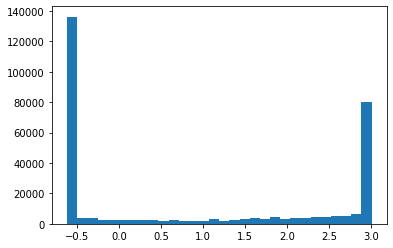

In [66]:
plt.hist(centers.cpu().detach().numpy().flatten(), bins=30)

(array([1.00000e+00, 2.00000e+00, 5.00000e+00, 8.00000e+00, 4.00000e+00,
        1.20000e+01, 1.30000e+01, 2.70000e+01, 3.20000e+01, 4.50000e+01,
        5.60000e+01, 9.50000e+01, 1.75000e+02, 2.12000e+02, 2.97000e+02,
        6.50000e+02, 1.75300e+03, 5.58600e+03, 6.52270e+04, 1.45128e+05,
        7.14340e+04, 1.31860e+04, 2.26000e+03, 6.32000e+02, 2.97000e+02,
        5.10000e+01, 4.00000e+00, 3.00000e+00, 2.00000e+00, 3.00000e+00]),
 array([-5.356752  , -5.0581355 , -4.759519  , -4.4609027 , -4.1622863 ,
        -3.8636696 , -3.5650532 , -3.2664368 , -2.9678202 , -2.6692038 ,
        -2.3705873 , -2.071971  , -1.7733544 , -1.474738  , -1.1761215 ,
        -0.87750506, -0.5788886 , -0.28027216,  0.01834431,  0.31696075,
         0.6155772 ,  0.9141937 ,  1.2128102 ,  1.5114266 ,  1.8100431 ,
         2.1086595 ,  2.407276  ,  2.7058923 ,  3.004509  ,  3.3031254 ,
         3.6017418 ], dtype=float32),
 <a list of 30 Patch objects>)

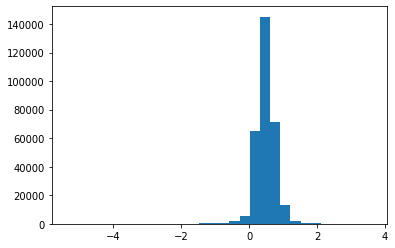

In [65]:
plt.hist(pred_centers.cpu().detach().numpy().flatten(), bins=30)

In [13]:
for img, center, label in dataloader:
    out = net(img)
    break

In [852]:
nn.MSELoss()(out, center)

tensor(2.5689, grad_fn=<MseLossBackward>)

In [857]:
disc = Discriminator(8)

In [859]:
disc(out)

tensor([[0.5451, 0.5004, 0.5394, 0.4930, 0.4963, 0.4768, 0.5000, 0.5339]],
       grad_fn=<SigmoidBackward>)

In [163]:
decode2 = DecoderBlock(256,128)
out2 = decode2(out1)
out2.size()

torch.Size([1, 128, 32, 50])

In [16]:
class CENet(nn.Module):
    def __init__(self):
        super(CENet, self).__init__()
        self.encoder = models.vgg16_bn(pretrained=False).features
        #self.fc = nn.Sequential(nn.Linear(),
        #                        nn.Linear())
        
        self.decoder = nn.Sequential(
                        # The padding size should design for different input size
                        DecoderBlock(512,256, padding=(1,0), output_padding = (1,0)),
                        DecoderBlock(256,128),
                        DecoderBlock(128,64),
                        DecoderBlock(64,32))
        
        self.conv = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.conv(x)        
        return x


In [839]:
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding = 1)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        #self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super(Discriminator, self).__init__()
        self.conv1 = DiscBlock(3, 64)
        self.conv2 = DiscBlock(64,128)
        self.conv3 = DiscBlock(128,256)
        self.conv4 = DiscBlock(256,512)    
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return nn.Sigmoid()(x)

In [840]:
for img in dataloader:
    out = vgg(img)
    break

In [854]:
disc = Discriminator(6)

In [842]:
out = disc(img)

In [ ]:
disc(out)

In [843]:
out

tensor([[0.4734, 0.5003, 0.5239]], grad_fn=<SigmoidBackward>)

In [713]:
study_dict = {
    'US BIOPSY LIVER NONFOCAL':'liver',
    'US BIOPSY LIVER FOCAL': 'liver',
    'US LYMPH NODE BIOPSY': 'biopsy',
    'US BIOPSY KIDNEY NONFOCAL (EITHER SIDE)': 'kidney',
    'US PARACENTESIS THERAPEUTIC': 'paracentesis',
    'US BIOPSY TRANSPLANTED KIDNEY': 'kidney',
    'US PARACENTESIS DIAGNOSTIC AND THERAPEUTIC': 'paracentesis',
    'US THYROID BIOPSY': 'thyroid',
    'US PARACENTESIS DIAGNOSTIC': 'paracentesis',
    'US THORACENTESIS DIAGNOSTIC AND THERAPEUTIC': 'thoracentesis',
    'US THYROID ASPIRATION/FNA': 'thyroid',
    'US DRAINAGE INTERVENTION NOT OTHERWISE SPECIFIED': 'drainage',
    'US DRAINAGE ABDOMEN': 'drainage',
    'US DRAINAGE GALLBLADDER (CHOLECYSTOSTOMY)': 'liver',
    'US THORACENTESIS THERAPEUTIC (RIGHT)': 'thoracentesis',
    'US THORACENTESIS THERAPEUTIC (LEFT)': 'thoracentesis',
    'US BIOPSY MESENTERY': 'biopsy',
    'US NECK SOFT TISSUE BIOPSY': 'biopsy',
    'US DRAINAGE CATHETER PLACEMENT': 'drainage',
    'US SOFT TISSUE BIOPSY': 'biopsy',
    'US DRAINAGE PELVIS': 'drainage',
    'US BIOPSY KIDNEY NONFOCAL (LEFT)': 'kidney',
    'US CHEST TUBE PLACEMENT (RIGHT)': 'thoracentesis',
    'US BIOPSY NOT OTHERWISE SPECIFIED': 'biopsy',
    'US ABDOMINAL PELVIC BIOPSY NOT OTHERWISE SPECIFIED': 'biopsy',
    'US CHEST TUBE PLACEMENT (LEFT)': 'thoracentesis',
    'CT BIOPSY LIVER FOCAL': 'liver',
    'US BIOPSY KIDNEY FOCAL (LEFT)': 'kidney',
    'US ASPIRATION ABDOMINAL COLLECTION': 'drainage',
    'CT LYMPH NODE BIOPSY': 'biopsy',
    'US DRAINAGE LIVER': 'liver',
    'US BIOPSY RETROPERITONEUM': 'biopsy',
    'US LYMPH NODE ASPIRATION/FNA': 'drainage',
    'US SOFT TISSUE ASPIRATION': 'drainage',
    'US ASPIRATION PELVIS': 'drainage',
    'US THORACENTESIS DIAGNOSTIC (RIGHT)': 'thoracentesis',
    'US THORACENTESIS DIAGNOSTIC (LEFT)': 'thoracentesis',
    'US DRAINAGE KIDNEY/PARARENAL (RIGHT)': 'drainage',
    'US HEAD/NECK INTERVENTION NOT OTHERWISE SPECIFIED': 'biopsy',
    'US BIOPSY KIDNEY FOCAL (RIGHT)': 'kidney',
    'CT ABDOMINAL PELVIC BIOPSY NOT OTHERWISE SPECIFIED': 'biopsy',
    'US DRAINAGE KIDNEY/PARARENAL (LEFT)': 'kidney',
    'IR PARACENTESIS (THERAPEUTIC)': 'paracentesis',
    'US PSEUDOANEURYSM THROMBIN INJECTION': 'biopsy',
    'IR PARACENTESIS (DIAGNOSTIC AND THERAPEUTIC)': 'paracentesis'    
}

In [31]:
labels = [study_dict[study] for study in dataset.df.Study if study in study_dict]

In [32]:
l, c = np.unique(np.array(labels), return_counts=True)

In [39]:
dataset.df.Study.value_counts().keys()

Index(['US BIOPSY LIVER NONFOCAL', 'US BIOPSY LIVER FOCAL',
       'US LYMPH NODE BIOPSY', 'US BIOPSY KIDNEY NONFOCAL (EITHER SIDE)',
       'US PARACENTESIS THERAPEUTIC', 'US BIOPSY TRANSPLANTED KIDNEY',
       'US PARACENTESIS DIAGNOSTIC AND THERAPEUTIC', 'US THYROID BIOPSY',
       'US PARACENTESIS DIAGNOSTIC',
       'US THORACENTESIS DIAGNOSTIC AND THERAPEUTIC',
       'US THYROID ASPIRATION/FNA',
       'US DRAINAGE INTERVENTION NOT OTHERWISE SPECIFIED',
       'US DRAINAGE ABDOMEN', 'US DRAINAGE GALLBLADDER (CHOLECYSTOSTOMY)',
       'US THORACENTESIS THERAPEUTIC (RIGHT)',
       'US THORACENTESIS THERAPEUTIC (LEFT)', 'US BIOPSY MESENTERY',
       'US NECK SOFT TISSUE BIOPSY', 'US DRAINAGE CATHETER PLACEMENT',
       'US SOFT TISSUE BIOPSY', 'US DRAINAGE PELVIS',
       'US BIOPSY KIDNEY NONFOCAL (LEFT)', 'US CHEST TUBE PLACEMENT (RIGHT)',
       'US BIOPSY NOT OTHERWISE SPECIFIED',
       'US ABDOMINAL PELVIC BIOPSY NOT OTHERWISE SPECIFIED',
       'US CHEST TUBE PLACEMENT (LEF

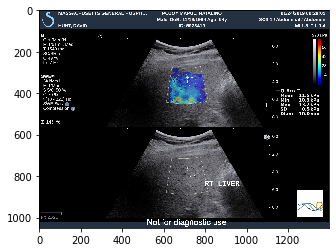

In [53]:
study = dataset.df.Study.value_counts().keys()[0]
idx = dataset.df[dataset.df.Study == study].index
i = random.choice(idx)
path = dataset.df.Image_Path.iloc[i]
ds = pydicom.dcmread(path)
plt.imshow(ds.pixel_array)

In [665]:
dataset.df.Study.value_counts()

US BIOPSY LIVER NONFOCAL                              3891
US BIOPSY LIVER FOCAL                                 1576
US LYMPH NODE BIOPSY                                   883
US BIOPSY KIDNEY NONFOCAL (EITHER SIDE)                850
US PARACENTESIS THERAPEUTIC                            844
US BIOPSY TRANSPLANTED KIDNEY                          630
US PARACENTESIS DIAGNOSTIC AND THERAPEUTIC             467
US THYROID BIOPSY                                      460
US PARACENTESIS DIAGNOSTIC                             260
US THORACENTESIS DIAGNOSTIC AND THERAPEUTIC            208
US THYROID ASPIRATION/FNA                              202
US DRAINAGE INTERVENTION NOT OTHERWISE SPECIFIED       190
US DRAINAGE ABDOMEN                                    173
US DRAINAGE GALLBLADDER (CHOLECYSTOSTOMY)              160
US THORACENTESIS THERAPEUTIC (RIGHT)                   109
US THORACENTESIS THERAPEUTIC (LEFT)                    105
US BIOPSY MESENTERY                                     